# One-dimensional bar subjected to tension/compression ('Hello World!' example)
***

## General formulation of the problem
---
Let us consider a beam with rectangular cross-section that is constant along the centerline of the beam, which coincides with the $x$-axis.
The beam is loaded with the volumetric force density $\mathbf{f}$ acting only in the direction of the $x$-axis. This results in extension or compression of the beam. The beam is fixed at the left end denoted by $\Gamma_{\text{D}}$.

In [26]:
%load_ext tikzmagic

The tikzmagic extension is already loaded. To reload it, use:
  %reload_ext tikzmagic


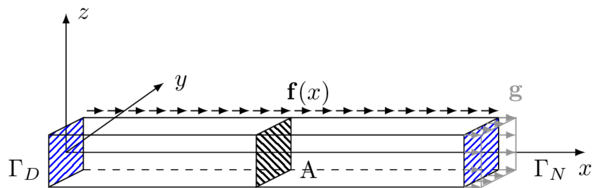

In [113]:
%%tikz -l patterns -s 600,320
\input{formulation.tikz};

### Governing equations
The problem for displacement $\mathbf{u}:\Omega \to \mathbb{R}^3$ of isotropic solid at small strains reads<a id='governing_eqns'></a>
\begin{align*}
	\text{div} \tau &= \mathbf{f} && \text{in } \Omega, \\
	\tau \mathbf{n} &= \mathbf{g} && \text{on } \Gamma_{\text{N}}, \\
	\mathbf{u} &= \mathbf{u}_D && \text{on } \Gamma_{\text{D}},
\end{align*}
where
\begin{align*}
	\tau = \lambda (\text{tr} \varepsilon(\mathbf{u})) \mathbb{I} + 2\mu \varepsilon(\mathbf{u})
\end{align*}
is the Cauchy stress tensor (with $\varepsilon(\mathbf{u})$ being the symmetric gradient of $\mathbf{u}$,
and $\lambda$ with $\mu$ the Lamé parameters),
$\mathbf{f}$ is the volumetric force density,
$\mathbf{g}$ is the normal traction on the Neumann part of the boundary of $\Omega$,
and $\mathbf{u}_D$ is the prescribed displacement at the Dirichlet part of $\partial \Omega$.
When reducing the problem for an axial dilatation and a radial compression we suppose
\begin{align*}
	\mathbf{u}
	=
	\begin{pmatrix}
		u_x (x) \\
		u_y(y,z) \\
		u_z(y,z)
	\end{pmatrix},
	\qquad
	\mathbf{f}
	=
	\begin{pmatrix}
		f_x(x) \\
		0 \\
		0
	\end{pmatrix},
\end{align*}
and that $\mathbf{g}$ is zero on the walls and points in the axial direction at both ends.
The system then partially separates; the equation for the component $u_x$ becomes independent.
Its solutions than enters the equations for $u_y$ and $u_z$ via the traction on the boundary
(here the Poisson's ratio comes into play); however, we are interested in finding solely $u_x$.
When we integrate its equation over the cross-section with an area $A$, we obtain
\begin{align*}
	A (\lambda + 2\mu)(u_x)'' = A f_x.
\end{align*}
Since we want to describe the material properties rather with Young modulus $E$ and Poisson's ratio $\nu$,
we substitute
\begin{align*}
	\lambda + 2\mu = \frac{E(1-\nu)}{(1+\nu)(1-2\nu)}.
\end{align*}
When supposing $\nu = 0$,
we end up with the reduced problem for $u:=u_x$
\begin{align*}
	A E u'' &= f \text{ in } (0,L), \\
	u(0) &= 0, \\
	AEu'(L) &= g,
\end{align*}
where $f(x) = Af_x(x)$ and $g = g_x(L)$.
Weak formulation<a id='weak_form'></a> is
\begin{align*}
	u \in V: \int_0^L A E u'(x) \varphi'(x) + f(x)\varphi(x)\, \text{d} x = g \varphi(L), \forall \varphi \in V\,,
\end{align*}
where <a id='function_space'></a>$V = \{ v \in H^1(0,L); v(0) = 0\}$.
Note that $H^1(0,L) \subset AC[0,L]$, thus $\varphi$ is defined pointwise.

---
#### Geometric derivation*
Displacement field is denoted by $u(x)$. If we cut off infinitesimal element then left cross section is moved by $u(x)$ and right cross section is moved by $u(x+\mathrm{d}x)$, therefore strain is 
\begin{equation}
    \varepsilon=\frac{u(x+\mathrm{d}x)-u(x)}{\mathrm{d}x}=u'(x).   
\end{equation}
Using 1D constitutive equation we get stress
\begin{equation}
    \sigma=\varepsilon E(x)=E(x)u'(x).
\end{equation}
\begin{figure}
    \centering
    \includegraphics[width=50mm]{Selection_052.png}
    \caption{Equilibrium on infinitesimal element}
    \label{fig:01}
\end{figure}
From equilibrium on infinitesimal element, see Figure \ref{fig:01}, we get following identity
\begin{equation}
    -\sigma(x)A(x) + b(x+\mathrm{d}x/2) + \sigma(x+\mathrm{d}x)A(x+\mathrm{d}x)=0,
\end{equation}
which can be expressed as
\begin{equation}
    \frac{\mathrm{d}}{\mathrm{d}x}\left(\sigma(x)A(x)\right)=-b(x).
\end{equation}
Using stress relation we get
\begin{equation}
    \frac{\mathrm{d}}{\mathrm{d}x}\left(E(x)A(x)u'(x)\right)=-b(x).
\end{equation}
If we suppose that $E(x)=\mathrm{const.}$ and $A(x)=\mathrm{const.}$, we get
\begin{equation}
    EAu''(x)=-b(x)
\end{equation}

## Implementation
---
First of all, we must import ``fenics`` library to ``python`` interface. Moreover we import ``pyplot`` library that is used for graph rendering.

In [53]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np

### Problem parameters
Let us set the material parameters of the problem. Following is the table that contains Young modulus and Poisson's ratio for some common materials.

| Material | Young modulus $E\ [GPa]$ | Poisson's ratio $\nu\ [-]$ |
| -------- |:-------------:| -----:|
| Rubber   | $0.01 - 0.1$  | $0.4999$ |
| Cork     | $0.02 - 0.03$    |   $0$ |
| Concrete | $30$      |    $0.1 - 0.2$ |
| Steel    | $200$      |    $0.27 - 0.30$ |

In [78]:
# --------------------
# Parameters
# --------------------
E = 10.0  # Young's modulus
A = 0.5  # Cross-section area of bar
L = 2.0  # Length of bar
n = 20  # Number of elements
f = 3.0  # Load intensity
g = 1.0 # External force

### Generating geometry of the problem

Next, we define the geometry of the problem. There is always possibility to use an external mesh defined in *.xml* file. In our case we use the predefined mesh provided directly by FEniCS. With the FEniCS object ``IntervalMesh(n, x_1, x_2)``, we can create equidistantly discretized one-dimensional mesh with $n$ elements between two end points $x_1$ and $x_2$.

>You can invoke a description of any function/object by ``help`` command. Try that for the object ``IntervalMesh``.

In [30]:
%%capture
# previous command supresses the output of this notebook cell, which is quite lenghty for the help command
help(fe.IntervalMesh)

In [62]:
# --------------------
# Geometry
# --------------------
mesh = fe.IntervalMesh(n, 0.0, L)

We can visually check the geometry of the mesh using the ``plot`` command.

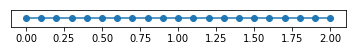

In [32]:
fe.plot(mesh)
plt.show() # this forces the plot to show in a pop-up window when in command line/script environment

### Function spaces definition
Now we define the function space that contain the solution and test functions by initializing the object ``FunctionSpace`` with three arguments. The first argument is the discretized domain contained in the ``mesh`` variable. Second and third are the type of the base functions and the order of these functions respectively.
We will present various types of function elements later in the course. In agreement with the [definition](#function_space) of the function spaces given in the first section, we define the conforming space of finite elements, that is the *Lagrange/Continous Galerkin* element (hence the acronym ``CG``) of order one. The last two lines initialize the test and trial functions specified by the function space.

In [63]:
# --------------------
# Function spaces
# --------------------
V = fe.FunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

### Boundary condtions
As a next step we specify the geometric boundary of the domain through which we apply the Dirichlet boundary condition. It is necessary to mark those entities of the mesh that constitute the boundaries $\Gamma_{\text{D}}$ and $\Gamma_{\text{N}}$.

In the following, ``on_boundary`` statement returns ``True`` for all points that lie on the boundary of the mesh and ``near(x,x0)`` checks whether ``x`` is close to ``x0`` (by default, within the tolerance given by the global constant ``DOLFIN_EPS``), which respectively gives the left and the right end of the beam only.

In [64]:
# ------------------------
# Boundary markings
# ------------------------
def left(x, on_boundary):
    return fe.near(x[0], 0.0) and on_boundary
def right(x, on_boundary):
    return fe.near(x[0], L) and on_boundary

>note: the value of ``DOLFIN_EPS`` is set to ``3e-16``

There is an equivalent way of marking the boundary. It employs the ``MeshFunction`` object that represents a numerically valued (Boolean valued is also possible) function defined on a mesh. The following ``for`` loop iterates through facets of the mesh (vertices in our example) and assigns the value 1 to the left boudnary and value 2 to the right boundary of the bar.

In [77]:
boundary = fe.MeshFunction("size_t", mesh, mesh.topology().dim()-1,0)
for v in fe.facets(mesh):
    if fe.near(v.midpoint()[0], 0.0):
        boundary[v] = 1 # left boundary
    elif fe.near(v.midpoint()[0], L):
        boundary[v] = 2 # right boundary

>note: it is preferable to set some default numerical value (e.g., 0) to all the other mesh facets, this can be done either by giving the last optional argument 0 in the initialization of the ``MeshFunction`` object or by calling ``boundary.set_all(0)`` **before** the ``for`` loop
---
#### Dirichlet boundary conditions
Dirichlet boundary condition are sometimes called essential, since they detemine the definition of the function spaces. In FEniCS, Dirichlet boundary conditions are implemented through the object ``DirichletBC`` initialized with three arguments: the function space, the prescribed value at the boundary, and a corresponding subdomain specified by the previously defined ``left`` function (or by the ``boundary`` variable and its numerical value at the desired facets).

In [99]:
# --------------------
# Boundary conditions
# --------------------
#bc = fe.DirichletBC(V, 0.0, left)
# Equivalently, using boundary variable:
bc = fe.DirichletBC(V, 0.0, boundary, 1)

#### Neumann boundary conditions
 In the [formulation](#governing_eqns) of the problem, we also prescribed a normal force $\mathbf{g}$ at the right boundary of the domain $\Gamma_{\text{N}}$. Such boundary interactions falls into the category of Neumann boundary condition, which is sometimes denoted as natural. The natural boundary conditions are reflected directly in the weak formulation of the problem.
 
 In the [weak formulation](#weak_form) above, the Neumann boundary condition appears as a term from the integration by parts formula. To include this term in our implementation of the problem, we first need to define the integrating measures that correspond to the manifolds representing the geometry of the mesh. To this end, we initialize the ``Measure`` object with input arguments that specify the integral type and the respective geometry to which the measure corresponds.

In [100]:
dx = fe.Measure("dx", mesh)
ds = fe.Measure("ds", subdomain_data = boundary)

We are now ready to give the weak form of the problem. One of the very nice features of FEniCS is that the implementation closely imitates the [weak formulation](#weak_form) given above.

In [101]:
# --------------------
# Weak form
# --------------------
a = E*A*fe.inner(fe.grad(u_tr),fe.grad(u_test))*fe.dx
# One can equivalently write the bilinear form in this one-dimensional problem as
# a = E*A*u_tr.dx(0),u_test.dx(0)*fe.dx
l = f*u_test*fe.dx - g*u_test*fe.ds(2)

>*note*: it is possible to access individual elements of the gradient ``grad`` of a function ``u`` via ``u.dx(i)``, where ``i`` specifies the derivative with respect to the ``i``-th coordinate and the enumeration starts with **zero**, do not confuse this with the measure object ``dx`` that specifies the integration domain

Finally, we call the solver to compute the linear algebraic system generated by the finite element method. FEniCS is prompted to do that by calling the ``solve`` function supplied by three parameters: linear variational equation, function that will store the resulting approximation and the problem specific Dirichlet boundary condition.

Let us first introduce the function ``u`` that will contain the finite element solution. In the code environment we define the object ``Function`` pertaining to the function space $V$.

In [102]:
# --------------------
# Solver
# --------------------
u = fe.Function(V)
fe.solve(a == l, u, bc)
# Equivalent implementation:
# F = a-l
# problem = fe.LinearVariationalProblem(fe.lhs(F),fe.rhs(F),u,bc)
# solver = fe.LinearVariationalSolver(problem)

## Post processing
In the final stage of our simulation we visualize the computational results. This task is easily handled by the ``matplotlib`` library that we imported at the beginning.

For many trivial problems, ours included, there is an exact solution. We can use this solution to benchmark our numerical results. The following cell introduces the exact solution and plots it next to the approximative result given by the finite element method.

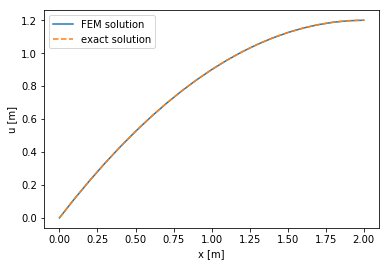

In [104]:
# --------------------
# Exact solution
# --------------------
x_ex = np.linspace(0, L, 200)
u_ex = [-0.5*f*x_ex_i**2/E/A + (0+f*L)*x_ex_i/E/A for x_ex_i in x_ex]

# --------------------
# Post-process
# --------------------
fe.plot(u)
plt.plot(x_ex, u_ex, "--")
plt.xlabel("x [m]")
plt.ylabel("u [m]")
plt.legend(["FEM solution","exact solution"])
plt.show()

## Complete code

In [ ]:
import fenics as fe
import matplotlib.pyplot as plt
import numpy as np

# --------------------
# Parameters
# --------------------
E = 10.0  # Young's modulus
A = 0.5  # Cross-section area of bar
L = 2.0  # Length of bar
n = 20  # Number of elements
f = 3.0  # Load intensity
g = 1.0 # External force

# --------------------
# Geometry
# --------------------
mesh = fe.IntervalMesh(n, 0.0, L)

fe.plot(mesh)
plt.show()

# --------------------
# Function spaces
# --------------------
V = fe.FunctionSpace(mesh, "CG", 1)
u_tr = fe.TrialFunction(V)
u_test = fe.TestFunction(V)

# --------------------
# Boundary marking
# --------------------
boundary = fe.MeshFunction("size_t", mesh, mesh.topology().dim()-1,0)
for f in fe.facets(mesh):
    if fe.near(f.midpoint()[0], 0.0):
        boundary[f] = 1 # left boundary
    elif fe.near(f.midpoint()[0], L):
        boundary[f] = 2 # right boundary

dx = fe.Measure("dx", mesh)
ds = fe.Measure("ds", subdomain_data = boundary)
        
# --------------------
# Boundary conditions
# --------------------
bc = fe.DirichletBC(V, 0.0, left)

# --------------------
# Weak form
# --------------------
a = E*A*u_tr.dx(0)*u_test.dx(0)*fe.dx
l = f*u_test*fe.dx + g*u_test*fe.ds(2)

# --------------------
# Solver
# --------------------
u = fe.Function(V)
fe.solve(a == l, u, bc)

# --------------------
# Exact solution
# --------------------
x_ex = np.linspace(0, L, 200)
u_ex = [-0.5*f*x_ex_i**2/E/A + (0+f*L)*x_ex_i/E/A for x_ex_i in x_ex]

# --------------------
# Post-process
# --------------------
fe.plot(u)
plt.plot(x_ex, u_ex, "--")
plt.xlabel("x [m]")
plt.ylabel("u [m]")
plt.legend(["FEM solution","exact solution"])
plt.show()